In [0]:
# Step 1: Load data
file_path = "/databricks-datasets/bikeSharing/data-001/hour.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 2: Convert to Pandas for sklearn modeling
pdf = df.toPandas()

# Step 3: Feature selection and preprocessing
# Drop unwanted columns and choose predictors
features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'workingday', 'weathersit', 'season']
target = 'cnt'

X = pdf[features]
y = pdf[target]

# Optional: train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Fit a regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = y_true.values, y_pred
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Results")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


Linear Regression Results
MAE:  106.73
MAPE: 325.23%
R²:   0.3456


In [0]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Fit XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Results")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
XGBoost Results
MAE:  44.87
MAPE: 58.20%
R²:   0.8616


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# Load dataset
file_path = "/databricks-datasets/bikeSharing/data-001/hour.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
pdf = df.toPandas()

# Define features and target
features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'workingday', 'weathersit', 'season']
target = 'cnt'

X = pdf[features].copy()
y = pdf[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode cyclical features
def encode_cyclical_features(df, column, max_val):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

for col, max_val in [('hr', 24), ('weekday', 7)]:
    X_train = encode_cyclical_features(X_train, col, max_val)
    X_test = encode_cyclical_features(X_test, col, max_val)

# Drop original cyclical columns
X_train.drop(['hr', 'weekday'], axis=1, inplace=True)
X_test.drop(['hr', 'weekday'], axis=1, inplace=True)

# Convert categorical features to string for CatBoost
cat_features = ['season', 'weathersit']
X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

# Initialize CatBoost model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    loss_function='MAE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Fit model with validation set
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

# Predict and evaluate
y_pred = cat_model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 CatBoost Results")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


0:	learn: 135.5846384	test: 130.8492108	best: 130.8492108 (0)	total: 10.1ms	remaining: 10.1s
100:	learn: 56.5860824	test: 54.1625287	best: 54.1625287 (100)	total: 837ms	remaining: 7.45s
200:	learn: 50.8339976	test: 48.8875676	best: 48.8875676 (200)	total: 1.81s	remaining: 7.21s
300:	learn: 48.6327278	test: 47.3791859	best: 47.3791859 (300)	total: 2.63s	remaining: 6.1s
400:	learn: 46.9684407	test: 46.1852336	best: 46.1852336 (400)	total: 3.56s	remaining: 5.32s
500:	learn: 45.7456656	test: 45.4510936	best: 45.4510936 (500)	total: 4.39s	remaining: 4.37s
600:	learn: 44.9089786	test: 45.0085074	best: 45.0085074 (600)	total: 5.41s	remaining: 3.59s
700:	learn: 44.1917399	test: 44.6377212	best: 44.6377212 (700)	total: 6.27s	remaining: 2.67s
800:	learn: 43.6414724	test: 44.3578549	best: 44.3578549 (800)	total: 7.09s	remaining: 1.76s
900:	learn: 43.1229006	test: 44.1674234	best: 44.1674234 (900)	total: 7.86s	remaining: 864ms
999:	learn: 42.5717005	test: 43.9108468	best: 43.9108468 (999)	total: 8

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats.mstats import winsorize

# ──────────────────────────────────────────────
# 1. LOAD DATA
# ──────────────────────────────────────────────
# You can read with Spark as before, then convert to pandas
file_path = "/databricks-datasets/bikeSharing/data-001/hour.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
pdf = df.toPandas()

# ──────────────────────────────────────────────
# 2. CLEAN & PREPARE FEATURES
# ──────────────────────────────────────────────
# Drop features that cause redundancy or multicollinearity
for col in ['casual', 'registered', 'atemp']:
    if col in pdf.columns:
        pdf = pdf.drop(columns=col)

# Winsorize mild outliers (trim 1 % tails)
for col in ['weathersit', 'hum', 'windspeed']:
    pdf[col] = winsorize(pdf[col], limits=[0.01, 0.01])

# Parse date and add additional features
pdf['dteday'] = pd.to_datetime(pdf['dteday'])
pdf['year']  = pdf['dteday'].dt.year
pdf['month'] = pdf['dteday'].dt.month
pdf['day']   = pdf['dteday'].dt.day

# Encode cyclical time-related variables
for col, max_val in [('hr', 24), ('weekday', 7),
                     ('month', 12), ('day', 31)]:
    pdf[f'{col}_sin'] = np.sin(2 * np.pi * pdf[col] / max_val)
    pdf[f'{col}_cos'] = np.cos(2 * np.pi * pdf[col] / max_val)

# Define feature list – include categorical and newly engineered features
feature_cols = [
    'temp', 'hum', 'windspeed', 'workingday', 'holiday',
    'weathersit', 'season',
    'year', 'month', 'day',
    'hr_sin','hr_cos','weekday_sin','weekday_cos',
    'month_sin','month_cos','day_sin','day_cos'
]

# Prepare inputs and apply log transform to target
X = pdf[feature_cols].copy()
y = np.log1p(pdf['cnt'])   # log(1 + cnt) to handle skew/outliers

# Identify categorical columns for CatBoost (use string dtype)
categorical = ['season', 'weathersit', 'holiday', 'workingday']
X[categorical] = X[categorical].astype(str)

# ──────────────────────────────────────────────
# 3. TRAIN–TEST SPLIT
# ──────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# CatBoost needs categorical indices (positions) rather than names
cat_indices = [feature_cols.index(col) for col in categorical]

# ──────────────────────────────────────────────
# 4. BASIC HYPER-PARAMETER SEARCH (GRIDSEARCHCV)
# ──────────────────────────────────────────────
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.05, 0.07],
    'iterations': [1000, 1500],
    'l2_leaf_reg': [3, 5],
}
cat_model = CatBoostRegressor(
    loss_function='MAE',
    random_seed=42,
    verbose=False
)
grid = GridSearchCV(
    cat_model,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
# Fit grid search (cat_features parameter must be passed to fit)
grid.fit(X_train, y_train, cat_features=cat_indices)
best_model = grid.best_estimator_

# Fit best model using early stopping on validation set
best_model.fit(
    X_train, y_train,
    cat_features=cat_indices,
    eval_set=(X_test, y_test),
    verbose=100,
    early_stopping_rounds=50
)

# ──────────────────────────────────────────────
# 5. EVALUATION
# ──────────────────────────────────────────────
# Predict in log space and invert the transform
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)        # inverse of log1p
y_test_orig = np.expm1(y_test)       # invert test target too

# Compute metrics on the original scale
mae  = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100
r2   = r2_score(y_test_orig, y_pred)

print(f"\n📊 CatBoost Results")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


0:	learn: 1.0712521	test: 1.0529514	best: 1.0529514 (0)	total: 10.6ms	remaining: 15.8s
100:	learn: 0.2058524	test: 0.2143177	best: 0.2143177 (100)	total: 1.08s	remaining: 15s
200:	learn: 0.1752850	test: 0.1912656	best: 0.1912656 (200)	total: 2.33s	remaining: 15.1s
300:	learn: 0.1598042	test: 0.1825755	best: 0.1825755 (300)	total: 3.54s	remaining: 14.1s
400:	learn: 0.1490818	test: 0.1783468	best: 0.1783468 (400)	total: 4.79s	remaining: 13.1s
500:	learn: 0.1411487	test: 0.1762504	best: 0.1762406 (499)	total: 6.04s	remaining: 12.1s
600:	learn: 0.1354422	test: 0.1748865	best: 0.1748865 (600)	total: 7.23s	remaining: 10.8s
700:	learn: 0.1310250	test: 0.1740544	best: 0.1740484 (699)	total: 8.21s	remaining: 9.36s
800:	learn: 0.1273096	test: 0.1732318	best: 0.1732097 (798)	total: 9.3s	remaining: 8.12s
900:	learn: 0.1244346	test: 0.1726385	best: 0.1726277 (897)	total: 10.3s	remaining: 6.85s
1000:	learn: 0.1215313	test: 0.1720711	best: 0.1720711 (1000)	total: 11.5s	remaining: 5.73s
1100:	learn: 0

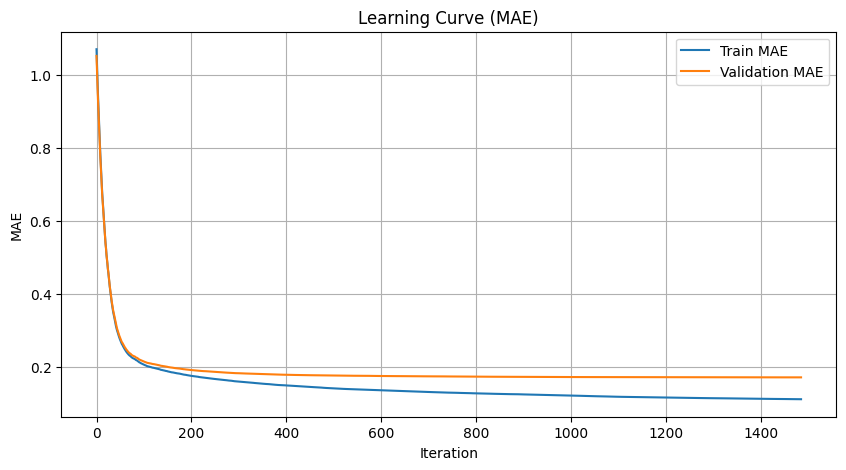

In [0]:
import matplotlib.pyplot as plt

# Extract metrics from the model
evals = best_model.get_evals_result()
train_error = evals['learn']['MAE']
valid_error = evals['validation']['MAE']

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_error, label='Train MAE')
plt.plot(valid_error, label='Validation MAE')
plt.title("Learning Curve (MAE)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


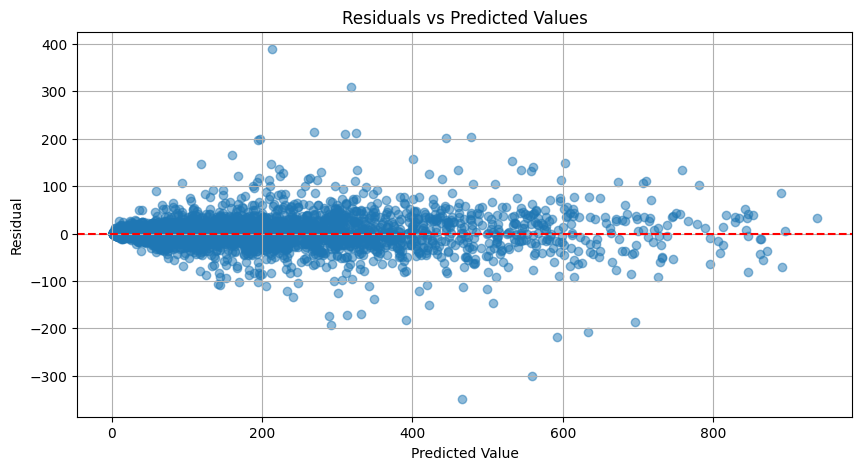

In [0]:
residuals = y_test_orig - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.grid(True)
plt.show()


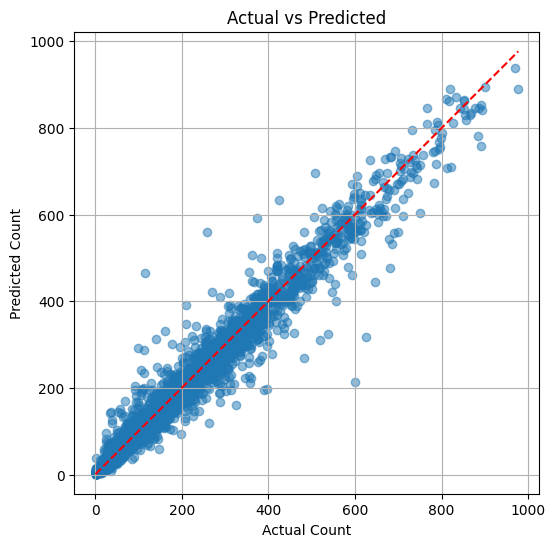

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()],
         color='red', linestyle='--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.grid(True)
plt.axis('equal')
plt.show()


In [0]:
bins = [0, 50, 100, 200, 300, 400, 500, 600, np.inf]
labels = ['0–50', '51–100', '101–200', '201–300', '301–400', '401–500', '501–600', '600+']
y_binned = pd.cut(y_test_orig, bins=bins, labels=labels)

res_df = pd.DataFrame({
    'actual': y_test_orig,
    'predicted': y_pred,
    'bin': y_binned
})
res_df['abs_error'] = np.abs(res_df['actual'] - res_df['predicted'])
res_df['pct_error'] = np.where(res_df['actual'] != 0,
                               res_df['abs_error'] / res_df['actual'],
                               np.nan)

# Aggregate stats
summary = res_df.groupby('bin').agg({
    'abs_error': 'mean',
    'pct_error': lambda x: np.mean(x) * 100
}).rename(columns={'abs_error': 'MAE', 'pct_error': 'MAPE (%)'})

summary = summary.loc[labels].round(2)
display(summary)

MAE,MAPE (%)
5.87,45.92
14.62,19.83
18.94,13.3
24.84,10.12
33.78,9.74
37.3,8.37
37.53,6.85
51.53,7.38


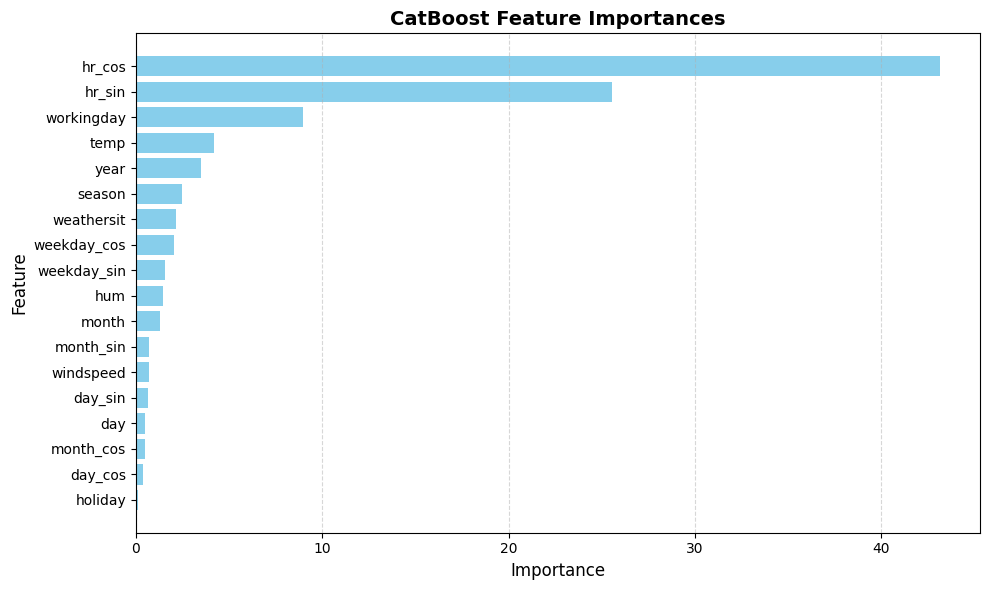

In [0]:
import matplotlib.pyplot as plt

# Get and sort feature importances
importances = best_model.get_feature_importance(prettified=True)
importances_sorted = importances.sort_values(by='Importances', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature Id'], importances_sorted['Importances'], color='skyblue')
plt.gca().invert_yaxis()  # Most important at the top
plt.title('CatBoost Feature Importances', fontsize=14, weight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
